# **IMPACT OF THE SELECTED FEATURES IN THE MODEL**

To predict the *next year* GDP growth for each country in the world are been used the following 50 features.

In [33]:
import sys
sys.path.append("..") # append the directory above where the databese is.
from utils import config
import pandas as pd
import numpy as np
import sqlite3
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### disable scientific notation in pandas
pd.set_option('display.float_format', '{:.2f}'.format) ### display up to 2 decimal pts

In [34]:
with sqlite3.connect(config.DATABASE_PATH) as connection:
    df = pd.read_sql("SELECT * FROM CountryIndicators", connection)

In [35]:
def clean_and_pivote(df):
    countries_gdp = df[df["IndicatorCode"] == config.GDP]["CountryCode"].to_list() #countries with gdp
    countries = df["CountryCode"].unique()
    countries_no_gdp = list(set(sorted(countries)) - set(sorted(countries_gdp))) # set difference =  countries with no gdp

    return df.pivot(index=["CountryCode","Year"], columns="IndicatorCode", values="Value").drop(countries_no_gdp)

In [47]:
df_cleaned = clean_and_pivote(df)
df_cleaned = df_cleaned[config.FEATURES]
df_cleaned.drop(index=range(1960, 1980), level="Year", inplace=True)

(7378, 50)

In [42]:
df_features = df_cleaned.copy()
df_target = df_cleaned.pop(config.GDP)
df_features.drop(index=2010, level="Year", inplace=True)
df_target.drop(index=1980, level="Year", inplace=True)

In [43]:
X = df_features
y = df_target.to_frame()
# genereate imputed dataframes by mean
X_imp = X.fillna(X.mean())
X_imp = np.array(X_imp)
y_imp = y.fillna(y.mean())
y_imp = np.array(y_imp)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.2, random_state=1)

In [45]:
model = xgb.XGBRegressor(max_depth=9, learning_rate=0.01, subsample=0.8, n_estimators=1000, base_score=y_train.mean())
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name', 'feature_importance_vals'])

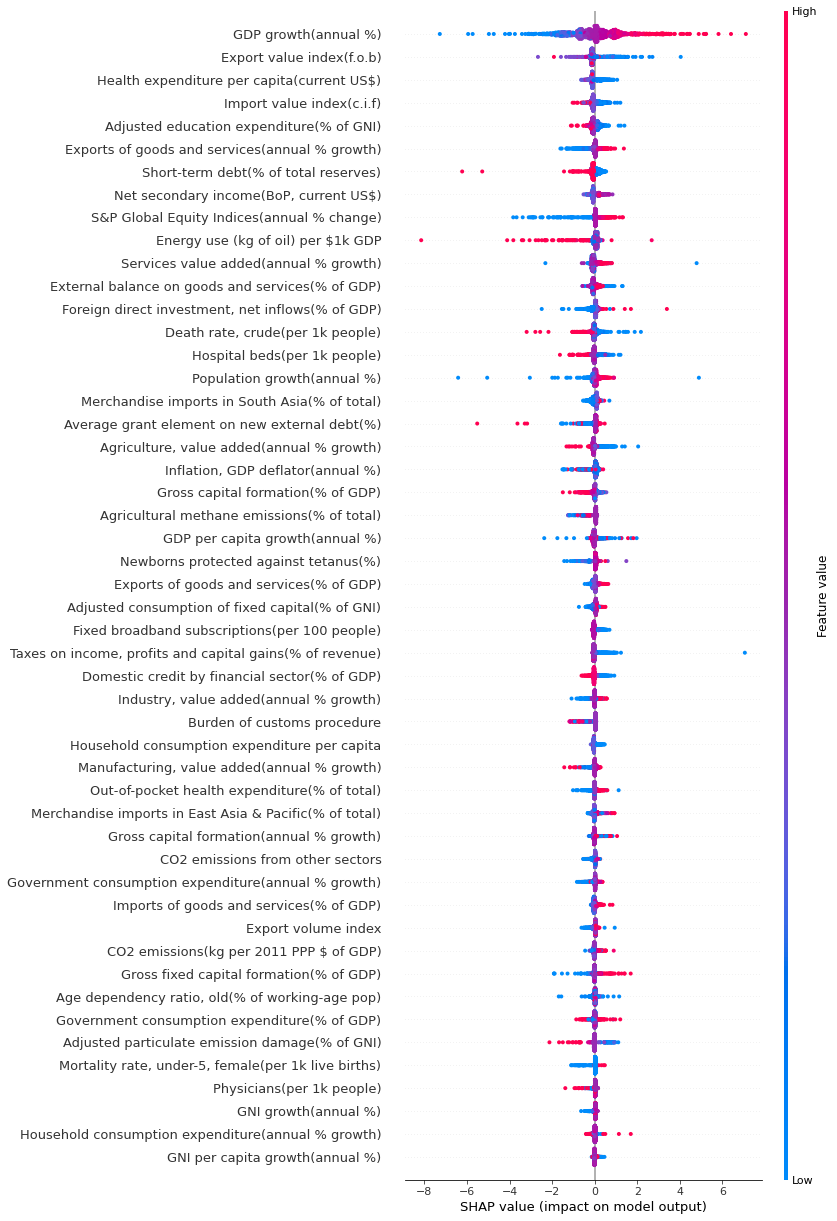

In [31]:
shap.summary_plot(shap_values, X_test, show=False, max_display=50, 
                  feature_names=list(config.FEATURE_LABELS))

In this plot we can see the impact of each 50 features in the model, in descending order. The most important feature, by far, is the value of the *GDP Growth (annual \%) of the actual year*, which makes sense given that we are trying to predict the *GDP Growth of the next year*. Both variables are directly correlated, high values of *GDP Growth of the actual year* imply a positive impact in the predictions of the *GDP Growth of the next year*, this positive relationship appears, to a lesser extent, in other features like *Exports of goods and services (annual % growth)*, *S&P Global Equity Indices (annual % change)*, etc. The other hand they are negative relations, for example for lower values of *Import value index (c.i.f)* we obtain higher predictions of *GDP Growth of the next year*.

## **Correlation matrix** 

Furthermore we can compute the correlation matrix to obtain more information about the relation between the features.

In [49]:
corr = df_cleaned.corr()
corr.columns = list(config.FEATURE_LABELS)
corr.index = list(config.FEATURE_LABELS)
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

The red values imply a postive relation and the blue values a negative relation, the intesity of the colour represents the intensity of the relation, more intense colour more strongly correlated are the features and less instense wekear correlated are. For example, the more positively correlated feature with *GDP Growth (annual %)* is eventually *GDP per capita growth(annual %)* (0.97) and the more negatively correlated feature is *Fixed broadband subscriptions(per 100 people)* (-0.27).